In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Set Directories
train_dir = '/kaggle/input/brain-tumor/Training'
test_dir = '/kaggle/input/brain-tumor/Testing'

In [11]:
# Image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32


In [12]:
# Preprocess grayscale to 3 channels
def preprocess_image(image):
    if len(image.shape) == 2:  # Grayscale image
        image = np.stack((image,) * 3, axis=-1)  # Duplicate channels
    return image

In [23]:
#Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [24]:
#Data augmentation
test_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Apply preprocess_image function here
)


In [15]:
train_datagen.preprocessing_function = preprocess_image # Apply preprocess_image 
test_datagen.preprocessing_function = preprocess_image # Apply preprocess_image 

In [25]:
# Load Images and Apply Preprocessing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'  # Ensure it's in 3 channels (RGB)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',  # Ensure it's in 3 channels (RGB)
    shuffle=False  # Keep order consistent for evaluation
)


Found 5712 images belonging to 4 classes.
Found 1302 images belonging to 4 classes.


In [26]:
# Display Class Imbalance
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
print(f"Class Distribution: {np.bincount(class_counts)}")

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_counts),
    y=class_counts
)
class_weights = dict(enumerate(class_weights))
print(f"Computed Class Weights: {class_weights}")


Class Distribution: [1321 1339 1595 1457]
Computed Class Weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


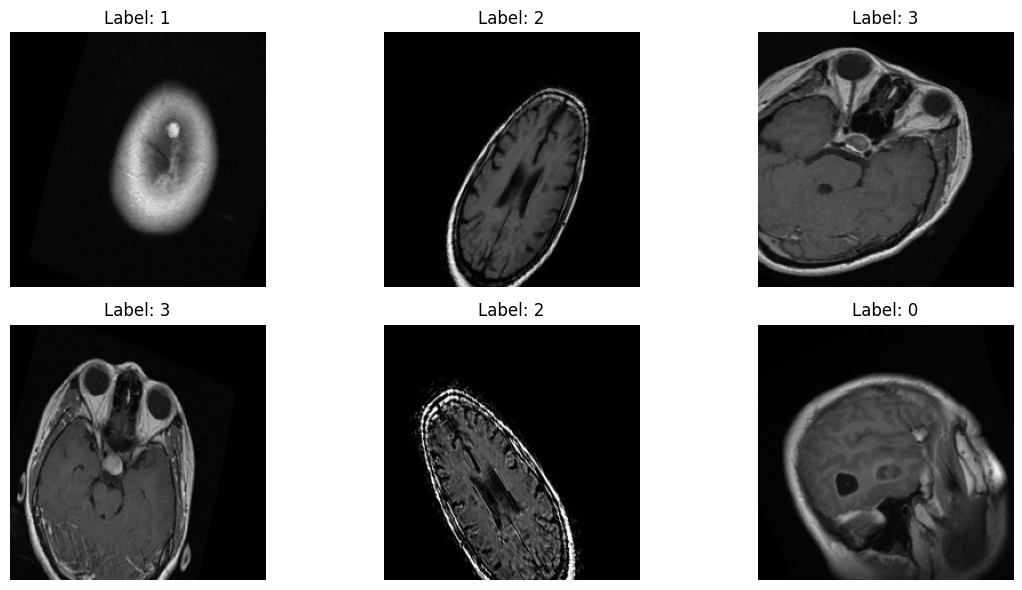

In [27]:
# Visualize Some Augmented Images
def visualize_augmented_images(generator, num_images=6):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Label: {np.argmax(y_batch[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_augmented_images(train_generator)


In [29]:
# Create VGG16 Model with Fine-Tuning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the initial layers (first 15 layers)
for layer in base_model.layers[:15]:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning (from layer 15 onwards)
for layer in base_model.layers[15:]:
    layer.trainable = True

In [30]:
# Define Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(len(class_labels), activation='softmax')
])


In [31]:
# Compile the model
# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


In [32]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

In [33]:
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [34]:
# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 99s 471ms/step - accuracy: 0.5938 - loss: 0.9252 - val_accuracy: 0.8266 - val_loss: 0.4999 - learning_rate: 1.0000e-04
Epoch 2/20
  1/178 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.8750 - loss: 0.4297

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8750 - loss: 0.4297 - val_accuracy: 0.9545 - val_loss: 0.2466 - learning_rate: 1.0000e-04
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 360ms/step - accuracy: 0.8632 - loss: 0.3588 - val_accuracy: 0.8875 - val_loss: 0.3044 - learning_rate: 1.0000e-04
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8125 - loss: 0.3855 - val_accuracy: 1.0000 - val_loss: 0.0586 - learning_rate: 1.0000e-04
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 355ms/step - accuracy: 0.9113 - loss: 0.2673 - val_accuracy: 0.8953 - val_loss: 0.2699 - learning_rate: 1.0000e-04
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 0.5251 - val_accuracy: 1.0000 - val_loss: 0.0471 - learning_rate: 1.0000e-04
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 368ms/step - accuracy: 0.9277 - loss: 0.2080 - val_accuracy: 0.9109 - val_loss: 0.2409 - learning_rate: 1.0000e-04
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1

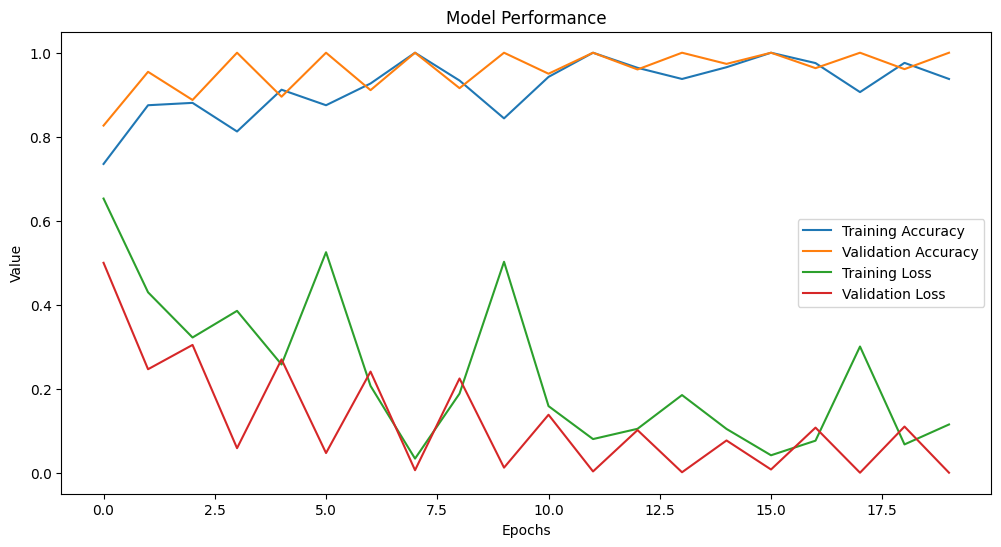

In [35]:
# Visualize Training Results
def plot_results(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_results(history)


In [36]:
# Evaluate Model
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step


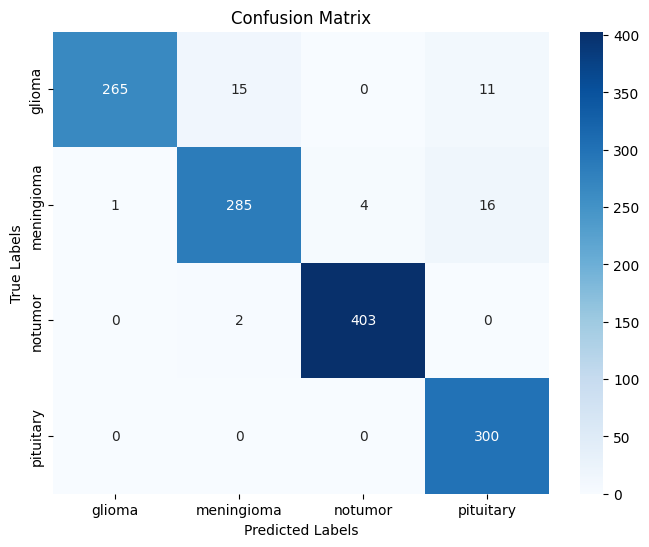

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [38]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.91      0.95       291
  meningioma       0.94      0.93      0.94       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.92      1.00      0.96       300

    accuracy                           0.96      1302
   macro avg       0.96      0.96      0.96      1302
weighted avg       0.96      0.96      0.96      1302



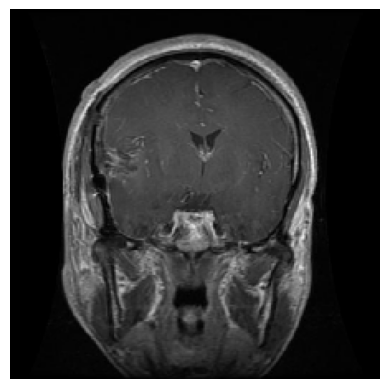

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Tumor Class: glioma, Confidence: 1.00


In [46]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Predict Single Image
image_path = "/kaggle/input/brain-tumor/Testing/glioma/Te-gl_0038.jpg"
img = load_img(image_path, target_size=(img_width, img_height))

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

# Preprocess Image
img_array = img_to_array(img)
img_array = preprocess_image(img_array)  # Apply preprocess_image function here
img_array = np.expand_dims(img_array / 255.0, axis=0)  # Normalize and expand dimensions

# Make Prediction
predictions = model.predict(img_array)
class_index = np.argmax(predictions)
confidence = predictions[0][class_index]

# Class labels and final result
predicted_label = class_labels[class_index]
print(f"Predicted Tumor Class: {predicted_label}, Confidence: {confidence:.2f}")
